<a href="https://colab.research.google.com/github/JG91/CNNPRE/blob/main/cnnpre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap-learn
!pip install hdbscan

In [ ]:
# !apt-get update

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc 

In [ ]:
import sklearn
from sklearn.cluster import KMeans
import os
import sys
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image as im
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import umap.umap_ as umap
import hdbscan
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def print_metrics(predicts):
  print("Rand Score: ",adjusted_rand_score(packet['type'], predicts))
  print("Mutial Info Score: ",adjusted_mutual_info_score(packet['type'], predicts))
  print("Homogeneity: ",metrics.homogeneity_score(packet['type'], predicts))
  print("Completenetss: ",metrics.completeness_score(packet['type'], predicts))
  print("V_Measure(beta=0.1): ",metrics.v_measure_score(packet['type'], predicts,beta=0.1))
  print("V_Measure(beta=0.2): ",metrics.v_measure_score(packet['type'], predicts,beta=0.2))
  print("V_Measure(beta=0.5): ",metrics.v_measure_score(packet['type'], predicts,beta=0.4))
  print("V_Measure: ",metrics.v_measure_score(packet['type'], predicts))
  print("\n")

In [ ]:
def draw_newconfmatrix(predicts):
  df_confusion = pd.crosstab(packet['type'], predicts, rownames=['Actual'], colnames=['Predicted'])
  # df_confusion
  plt.matshow(df_confusion, cmap='Blues') # imshow
  plt.title("Test")
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  ytick_marks = np.arange(len(df_confusion.index))
  plt.xticks(tick_marks, df_confusion.columns)
  plt.yticks(ytick_marks, df_confusion.index)
  # plt.tight_layout()
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)

In [ ]:
def draw_confmatrix(predicts):
  """Draw Confusion Matrix"""
  cm = confusion_matrix(packet['type'], predicts.astype(str))
  ConfusionMatrixDisplay(cm).plot()

In [ ]:
# Finding best K for clustering with Elbow Method
def bestkm(featuresvectore):
  fig, ax = plt.subplots()

  visualizer = KElbowVisualizer(KMeans(), k=(1,11),ax=ax)
  visualizer.fit(featuresvectore)

  ax.set_xticks(range(1,11))
  visualizer.show()
  plt.show()
  print(f'Elbow Value is {visualizer.elbow_value_}')

  # Clustering
  kmeans = AgglomerativeClustering(n_clusters = visualizer.elbow_value_)
  kmeans.fit(featuresvectore)
  return kmeans.labels_

In [ ]:
n = 5000 # no. of packets

In [ ]:
data = pd.read_csv('GSM5000-hex.csv', dtype=str) # 

mtypes = data['type'].values
direction = data['direction'].values
bin = data['Full'].values

bin=bin[:n]
direction=direction[:n]
mtypes=mtypes[:n]

In [ ]:
data['type'].value_counts()

05    7431
01    5644
0f    1839
87    1352
07     505
02     503
09     119
Name: Channel_Type, dtype: int64

In [ ]:
packet = {
    'bin' : [],
    'extractedfeature' : [],
    'length' : np.zeros(n),
    'lengroup' : [],
    'direction' : [],
    'type' : [],
    }

In [ ]:
for l in range(n):
  # print(len(bin[l]))
  packet['length'][l]=len(bin[l])
  # print(packet['length'][l])

# packet['length'] 

In [ ]:
packet["type"]=mtypes

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(packet['length'].reshape(-1,1))
packet['lengroup'] = kmeans.labels_
# you can see the labels with:
# print(packet['length'])
# print(packet['lengroup'])

In [ ]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(direction.reshape(-1, 1))
packet['direction']=transformed.toarray()

In [ ]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(packet['lengroup'].reshape(-1,1))
packet['lengroup']=transformed.toarray()

In [ ]:
listofbins=[]
lens=[]
for i in range(bin.shape[0]):
  # print(i)
  if (packet['length'][i]) < maxlen:
    bin[i]=list(bin[i])
    bin[i] = bin[i] + [0] * max(0, maxlen - len(bin[i]))
  # print(len(bin[i]))
  listofbins.append(list(bin[i]))
  # lens.append(len(list(bin[i])))
# print(lens)
# print(max(lens))

    # print(len(j))
  # print(list(bin[i]))
packet['bin'] = np.array(listofbins,dtype=np.int32)

In [ ]:
print(packet['direction'].shape)
print(packet['type'].shape)
print(packet['bin'].shape)
print(packet['length'].shape)
print(packet['lengroup'].shape)

(5000, 2)
(5000,)
(5000, 184)
(5000,)
(5000, 1)


In [ ]:
# apply transfer learning by using Resnet50 as pretrained model
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet50(
    include_top = False, weights='imagenet', pooling='avg',
))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# freezing weights for 1st layer
MyModel.layers[0].trainable = False

In [ ]:
img = [] # list of images!
for g in range(len(packet['bin'])):
  img.append(cv2.resize(packet['bin'][g].astype('uint8'), (224, 224)))

In [ ]:
# img[1]

In [ ]:
print(len(img)) # (n)
print(img[0].shape) # 224 ,224

5000
(224, 224)


In [ ]:
for i in range(len(img)):
  img[i] = img[i].reshape(224,224,1) 

# reshaped_img  = np.expand_dims(reshaped_img, -1)

In [ ]:
print(img[0].shape) # (224, 224, 1)
print(len(img)) # n 

(224, 224, 1)
5000


In [ ]:
color_img =[]
for i in range(len(img)):
  color_img.append(cv2.cvtColor(img[i],cv2.COLOR_GRAY2RGB))

In [ ]:
len(color_img) # (n)

5000

In [ ]:
for i in range(len(color_img)):
  color_img[i] = tf.keras.applications.resnet50.preprocess_input(color_img[i])

In [ ]:
color_img_expanded = []
for i in range(len(color_img)):
  color_img_expanded.append(np.expand_dims(color_img[i], 0))

In [ ]:
print(len(color_img_expanded)) # n 1275
print(color_img_expanded[0].shape) # (1, 224, 224, 3)

5000
(1, 224, 224, 3)


In [ ]:
for i in range(len(color_img_expanded)):
  # print(f'{i+1}/{n}')
  extractedFeatures = MyModel.predict(color_img_expanded[i])
  extractedFeatures = np.array(extractedFeatures)
  packet["extractedfeature"].append(extractedFeatures.flatten())
packet['extractedfeature'] = np.array(packet['extractedfeature'], dtype = 'float64')

In [ ]:
print(packet['extractedfeature'].shape)

(5000, 2048)


In [ ]:
bin_umap = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    n_components=10,
    random_state=42
).fit_transform(packet['bin'])

In [ ]:
bin_umap_hamming = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    n_components=10,
    random_state=42,
    metric="hamming"
).fit_transform(packet['bin'])

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


In [ ]:
cnn_umap = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    n_components=10,
    random_state=42,
).fit_transform(packet['extractedfeature'])

In [ ]:
cnn_d = np.append(packet['extractedfeature'],packet['direction'],axis=1)
cnn_dl = np.append(cnn_d,packet['lengroup'],axis=1)
cnn_umap_d = np.append(cnn_umap,packet['direction'],axis=1)
cnn_umap_dl = np.append(cnn_umap_d,packet['lengroup'],axis=1)

print(packet['extractedfeature'].shape)
print(cnn_d.shape)
print(cnn_dl.shape)
print(cnn_umap.shape)
print(cnn_umap_d.shape)
print(cnn_umap_dl.shape)

(5000, 2048)
(5000, 2050)
(5000, 2051)
(5000, 10)
(5000, 12)
(5000, 13)


In [ ]:
km_bin = bestkm(packet['bin'])

In [ ]:
km_cnn = bestkm(packet['extractedfeature'])

In [ ]:
km_bin_umap = bestkm(bin_umap_hamming)

In [ ]:
km_cnn_umap = bestkm(cnn_umap)

In [ ]:
km_cnn_umap_d = bestkm(cnn_umap_d)

In [ ]:
km_cnn_umap_dl = bestkm(cnn_umap_dl)

In [ ]:
print("K-Means Binary, with K="+str(len(set(km_bin)))+":")
print_metrics(km_bin)

print("K-Means CNN, with K="+str(len(set(km_cnn)))+":")
print_metrics(km_cnn)

# print("K-Means Binary-UMAP, with K="+str(len(set(km_bin_umap)))+":")
# print_metrics(km_bin_umap)

print("K-Means CNN-UMAP, with K="+str(len(set(km_cnn_umap)))+":")
print_metrics(km_cnn_umap)

print("K-Means CNN-UMAP-Direction, with K="+str(len(set(km_cnn_umap_d)))+":")
print_metrics(km_cnn_umap_d)

print("K-Means CNN-UMAP-Direction-Length, with K="+str(len(set(km_cnn_umap_dl)))+":")
print_metrics(km_cnn_umap_dl)

K-Means Binary, with K=4:
Rand Score:  0.6213859517535346
Mutial Info Score:  0.6219416125733216
Homogeneity:  0.6428092345149717
Completenetss:  0.603281753132149
V_Measure(beta=0.1):  0.6390030555685949
V_Measure(beta=0.2):  0.635865502261584
V_Measure(beta=0.5):  0.629070181543265
V_Measure:  0.6224185645704168


K-Means CNN, with K=3:
Rand Score:  0.5126861409887395
Mutial Info Score:  0.5066724317523531
Homogeneity:  0.46809263297686377
Completenetss:  0.553284646037887
V_Measure(beta=0.1):  0.47473788517522164
V_Measure(beta=0.2):  0.4804214498351917
V_Measure(beta=0.5):  0.49341727763098575
V_Measure:  0.5071357510505309


K-Means CNN-UMAP, with K=3:
Rand Score:  0.6672251553276155
Mutial Info Score:  0.6805920813242634
Homogeneity:  0.6204408536997248
Completenetss:  0.7544055939583055
V_Measure(beta=0.1):  0.6306211746571755
V_Measure(beta=0.2):  0.6393635145430252
V_Measure(beta=0.5):  0.6594767199039909
V_Measure:  0.6808964761827162


K-Means CNN-UMAP-Direction, with K=3:
R

In [ ]:
min_cluster_size = int(n/100)
print(min_cluster_size)
min_samples = 10
hd_bin = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(packet['bin'])
hd_cnn = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(packet['extractedfeature'])
hd_bin_umap = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(bin_umap)
hd_bin_umaph = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(bin_umap_hamming)
hd_cnn_umap = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(cnn_umap)
hd_cnn_umap_d = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(cnn_umap_d)
hd_cnn_umap_dl = hdbscan.HDBSCAN(min_cluster_size,min_samples).fit_predict(cnn_umap_dl)

50


In [ ]:
print("HDBSCAN Binary")
print(str(len(set(hd_bin))))
print_metrics(hd_bin)

print("HDBSCAN CNN")
print(str(len(set(hd_cnn))))
print_metrics(hd_cnn)

print("HDBSCAN Binary-UMAP")
print(str(len(set(hd_bin_umap))))
print_metrics(hd_bin_umap)

print("HDBSCAN Binary-UMAP-Hamming")
print(str(len(set(hd_bin_umaph))))
print_metrics(hd_bin_umaph)

print("HDBSCAN CNN-UMAP")
print(str(len(set(hd_cnn_umap))))
print_metrics(hd_cnn_umap)

print("HDBSCAN CNN-UMAP-Direction")
print(str(len(set(hd_cnn_umap_d))))
print_metrics(hd_cnn_umap_d)

print("HDBSCAN CNN-UMAP-Direction-Length")
print(str(len(set(hd_cnn_umap_dl))))
print_metrics(hd_cnn_umap_dl)

HDBSCAN Binary
11
Rand Score:  0.6865167715488121
Mutial Info Score:  0.733094501108318
Homogeneity:  0.95172485165638
Completenetss:  0.5973695961367796
V_Measure(beta=0.1):  0.9030276371335009
V_Measure(beta=0.2):  0.8660977178317
V_Measure(beta=0.5):  0.7946065882749049
V_Measure:  0.7340178529168939


HDBSCAN CNN
12
Rand Score:  0.6885520986540465
Mutial Info Score:  0.7455207362747828
Homogeneity:  0.9754092042757334
Completenetss:  0.6045948735097237
V_Measure(beta=0.1):  0.9238955634060284
V_Measure(beta=0.2):  0.8849487207305091
V_Measure(beta=0.5):  0.8098430205640395
V_Measure:  0.7464884588220464


HDBSCAN Binary-UMAP
12
Rand Score:  0.6804836560155201
Mutial Info Score:  0.7089501773366793
Homogeneity:  0.9164728551940425
Completenetss:  0.5795569252715115
V_Measure(beta=0.1):  0.8704698207535086
V_Measure(beta=0.2):  0.8355201912090061
V_Measure(beta=0.5):  0.7677080247954933
V_Measure:  0.7100770278593959


HDBSCAN Binary-UMAP-Hamming
11
Rand Score:  0.6667689315860077
Mu

HDBSCAN Binary
HDBSCAN CNN
HDBSCAN Binary-UMAP
HDBSCAN Binary-UMAP-Hamming
HDBSCAN CNN-UMAP
HDBSCAN CNN-UMAP-Direction
HDBSCAN CNN-UMAP-Direction-Length


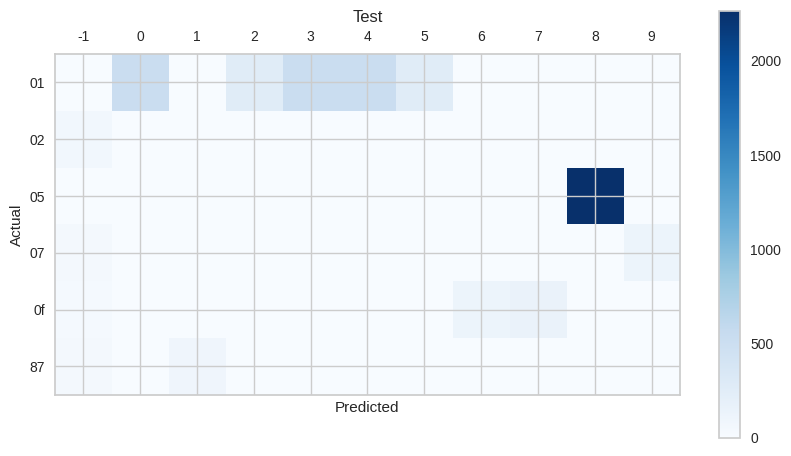

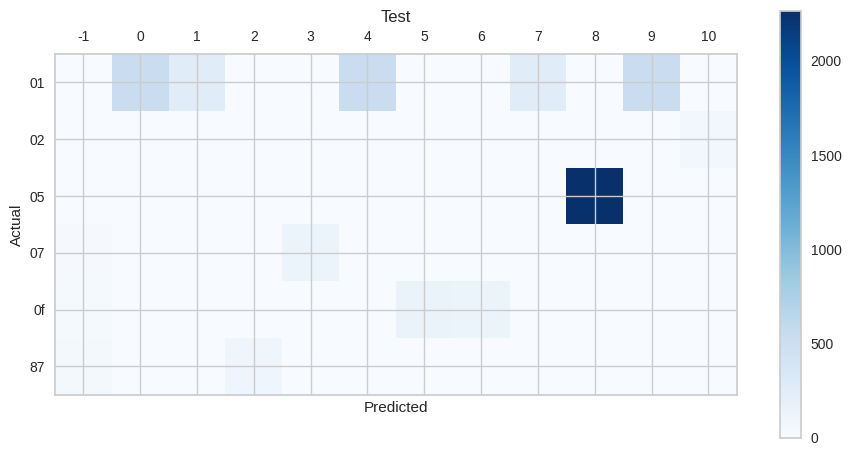

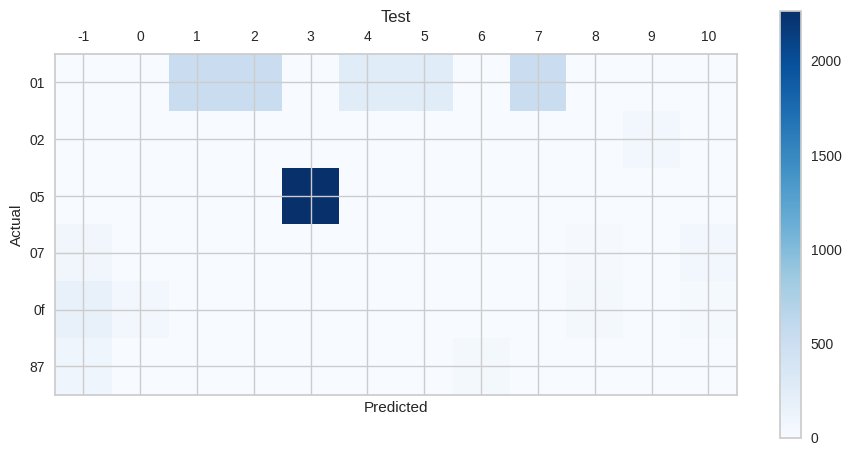

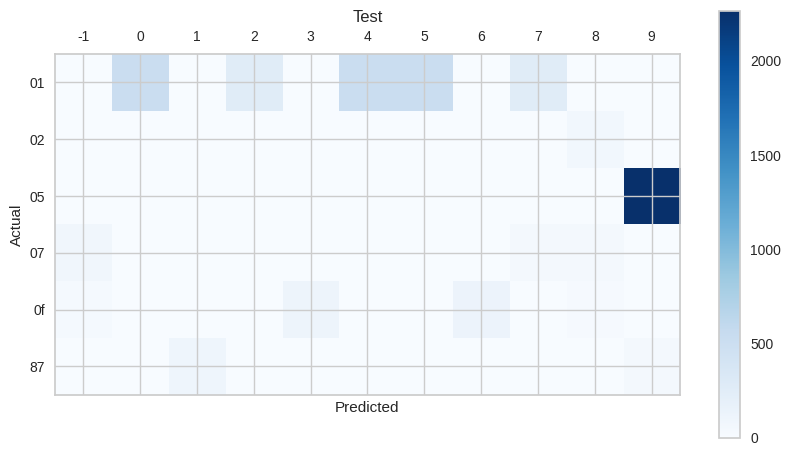

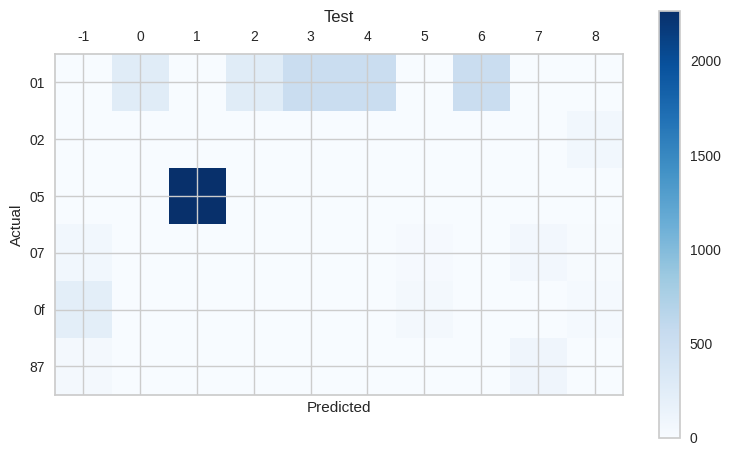

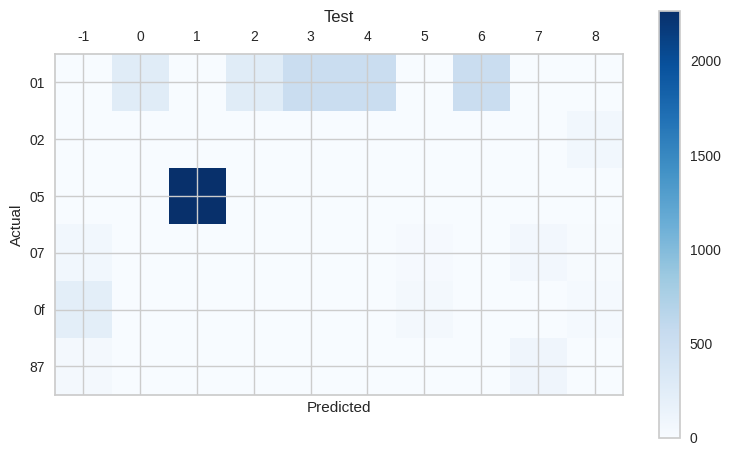

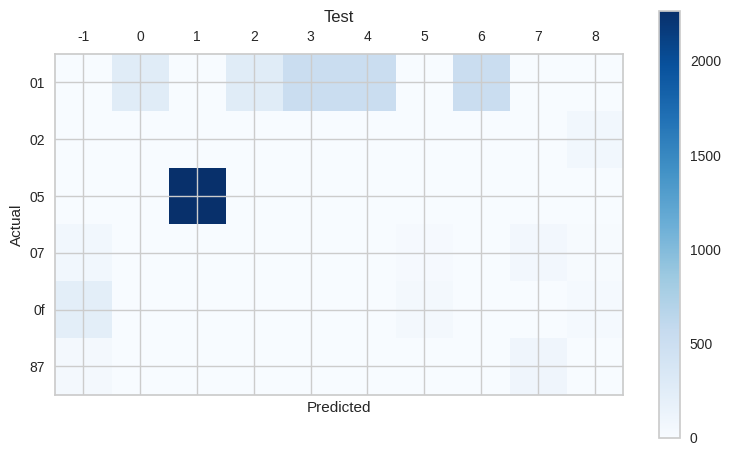

In [ ]:
print("HDBSCAN Binary")
draw_newconfmatrix(hd_bin)
print("HDBSCAN CNN")
draw_newconfmatrix(hd_cnn)
print("HDBSCAN Binary-UMAP")
draw_newconfmatrix(hd_bin_umap)
print("HDBSCAN Binary-UMAP-Hamming")
draw_newconfmatrix(hd_bin_umaph)
print("HDBSCAN CNN-UMAP")
draw_newconfmatrix(hd_cnn_umap)
print("HDBSCAN CNN-UMAP-Direction")
draw_newconfmatrix(hd_cnn_umap_d)
print("HDBSCAN CNN-UMAP-Direction-Length")
draw_newconfmatrix(hd_cnn_umap_dl)

In [ ]:
upgmal = AgglomerativeClustering(linkage='single',n_clusters=len(set(km_cnn_umap_dl)))
upgmal.fit(cnn_umap_dl)
upl_cnn_umap_dl = upgmal.labels_
# print('Cluster IDs:', cluster_ids)
# print(len(np.unique(cluster_ids)))
print("UPGMA Clustering Performance (with Elbow):\n")
print_metrics(upl_cnn_umap_dl)

UPGMA Clustering Performance (with Elbow):

Rand Score:  0.018162521601181713
Mutial Info Score:  0.1010283286721755
Homogeneity:  0.06235686883675875
Completenetss:  0.28589067394759254
V_Measure(beta=0.1):  0.06712838898516772
V_Measure(beta=0.2):  0.07170046214738993
V_Measure(beta=0.5):  0.08433767333346982
V_Measure:  0.1023826161957555




In [ ]:
upgmah = AgglomerativeClustering(linkage='single',n_clusters=len(set(hd_cnn_umap_dl)))
upgmah.fit(cnn_umap_dl)
uph_cnn_umap_dl = upgmah.labels_
# print('Cluster IDs:', cluster_ids)
# print(len(np.unique(cluster_ids)))
print("UPGMA Clustering Performance (n from hdbscan):\n")
print_metrics(uph_cnn_umap_dl)

UPGMA Clustering Performance (n from hdbscan):

Rand Score:  0.7229268213786022
Mutial Info Score:  0.6932790226834541
Homogeneity:  0.7277614391152519
Completenetss:  0.664138098651494
V_Measure(beta=0.1):  0.7214781280943954
V_Measure(beta=0.2):  0.7163243232520319
V_Measure(beta=0.5):  0.7052411247994661
V_Measure:  0.6944956662912197




In [ ]:
upgmam = AgglomerativeClustering(linkage='single',n_clusters=int((len(set(km_cnn_umap_dl))+len(set(hd_cnn_umap_dl)))/2))
upgmam.fit(cnn_umap_dl)
upm_cnn_umap_dl = upgmam.labels_
# print('Cluster IDs:', cluster_ids)
# print(len(np.unique(cluster_ids)))
print("UPGMA Clustering Performance (average n):\n")
print_metrics(upm_cnn_umap_dl)

UPGMA Clustering Performance (average n):

Rand Score:  0.06974625027629253
Mutial Info Score:  0.21342029328335718
Homogeneity:  0.15971944926613313
Completenetss:  0.33293382908047336
V_Measure(beta=0.1):  0.16764872628301603
V_Measure(beta=0.2):  0.17488382018457127
V_Measure(beta=0.5):  0.19322979008909083
V_Measure:  0.21587599295497267




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Go to the directory where your file is
%cd gdrive/MyDrive/Colab\ Notebooks
# Verify that now you see your notebooks
!ls


In [ ]:
# Convert
!jupyter nbconvert --to pdf cnnpre.ipynb